### Setup

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import functools
import einops
import requests
import pandas as pd
import io
import gc
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm import tqdm
from torch import Tensor
from typing import List, Dict, Optional, Tuple
from transformer_lens import HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
from jaxtyping import Float, Int
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from huggingface_hub import login as hf_login
import os

from scipy.linalg import svd

/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-12-19 17:15:00.318703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attem

In [3]:
# set HF_TOKEN in .env
token = os.environ.get("HF_TOKEN")
hf_login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
INFERENCE_DTYPE = torch.float16
SEED = 3252

LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"
PEFT_MODEL_PATH_LAT = "nlpett/llama-2-7b-chat-hf-LAT-layer4-hh"
PEFT_MODEL_PATH_AT = "nlpett/llama-2-7b-chat-hf-AT-hh"
print(f"Device: {DEVICE}")

LLAMA_CHAT_TEMPLATE = "\n[INST]{prompt}[/INST]\n"

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output dir: {OUTPUT_DIR.resolve()}")

Device: cuda
Output dir: /home/ubuntu/latent_refusal_geometry/outputs


### Load data & test data

In [5]:
def get_harmful_instructions() -> Tuple[List[str], List[str]]:
    url = 'https://raw.githubusercontent.com/llm-attacks/llm-attacks/main/data/advbench/harmful_behaviors.csv'
    response = requests.get(url)
    dataset = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    instructions = dataset['goal'].tolist()
    train, test = train_test_split(instructions, test_size=0.2, random_state=42)
    return train, test

def get_harmless_instructions() -> Tuple[List[str], List[str]]:
    hf_path = 'tatsu-lab/alpaca'
    dataset = load_dataset(hf_path)
    instructions = [
        dataset['train'][i]['instruction'] 
        for i in range(len(dataset['train']))
        if dataset['train'][i]['input'].strip() == '' # filter instructions wihtout inputs
    ]
    train, test = train_test_split(instructions, test_size=0.2, random_state=42)
    return train, test

harmful_train, harmful_test = get_harmful_instructions()
harmless_train, harmless_test = get_harmless_instructions()

print(f"Harmful instructions: {len(harmful_train)} train, {len(harmful_test)} test")
print(f"Harmless instructions: {len(harmless_train)} train, {len(harmless_test)} test")

Harmful instructions: 416 train, 104 test
Harmless instructions: 25058 train, 6265 test


### Load models & get activations

In [6]:
def load_base_model() -> HookedTransformer:
    base_model = AutoModelForCausalLM.from_pretrained(
        LLAMA_2_7B_CHAT_PATH,
        torch_dtype=INFERENCE_DTYPE,
        device_map="auto",
    )
    
    hooked_model = HookedTransformer.from_pretrained_no_processing(
        LLAMA_2_7B_CHAT_PATH,
        hf_model=base_model,
        dtype=INFERENCE_DTYPE,
        device=DEVICE,
        default_padding_side='left',
    )
    hooked_model.tokenizer.padding_side = 'left'
    hooked_model.tokenizer.pad_token = "[PAD]"
    
    del base_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return hooked_model

def load_peft_model(peft_path: str, model_name: str = "LAT") -> HookedTransformer:
    base_model = AutoModelForCausalLM.from_pretrained(
        LLAMA_2_7B_CHAT_PATH,
        torch_dtype=INFERENCE_DTYPE,
        device_map="auto",
    )

    # merge PEFT adapter    
    peft_model = PeftModel.from_pretrained(base_model, peft_path)
    peft_model = peft_model.to(INFERENCE_DTYPE)
    
    try:
        merged_model = peft_model.merge_and_unload()
        print(f"Merged {model_name} adapter")
    except AttributeError:
        merged_model = peft_model
    
    merged_model.eval()
    
    hooked_model = HookedTransformer.from_pretrained_no_processing(
        LLAMA_2_7B_CHAT_PATH,
        hf_model=merged_model,
        dtype=INFERENCE_DTYPE,
        device=DEVICE,
        default_padding_side='left',
    )
    
    hooked_model.tokenizer.padding_side = 'left'
    hooked_model.tokenizer.pad_token = "[PAD]"
    
    del merged_model, peft_model, base_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return hooked_model

# Load models into a dict
# ~14GB each in fp16

models = {}
#models['Baseline'] = load_base_model()
models['LAT'] = load_peft_model(PEFT_MODEL_PATH_LAT, "LAT")
models['AT'] = load_peft_model(PEFT_MODEL_PATH_AT, "AT")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Merged LAT adapter
Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Merged AT adapter
Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [7]:
allocated = torch.cuda.memory_allocated() / 1e9
reserved = torch.cuda.memory_reserved() / 1e9
print(f"\nGPU Memory: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved")


GPU Memory: 28.2GB allocated, 41.4GB reserved


In [8]:
def tokenize_instructions(
    tokenizer: AutoTokenizer,
    instructions: List[str]
) -> Int[Tensor, 'batch_size seq_len']:
    """Tokenize instructions using Llama-2 chat template."""
    prompts = [LLAMA_CHAT_TEMPLATE.format(prompt=instruction) for instruction in instructions]
    return tokenizer(prompts, padding=True, truncation=False, return_tensors="pt").input_ids

def get_activations(
    model: HookedTransformer,
    instructions: List[str],
    layer: int,
    batch_size: int = 32,
    position: int = -1  # Last token by default
) -> torch.Tensor:
    # Get activations at layer n for a given instruction
    # run_with_cache for residual stream activations as we go

    tokenize_fn = functools.partial(tokenize_instructions, tokenizer=model.tokenizer)
    activations = []
    
    for i in tqdm(range(0, len(instructions), batch_size), desc=f"Layer {layer}"):
        batch = instructions[i:i+batch_size]
        toks = tokenize_fn(instructions=batch).to(DEVICE)
        
        with torch.no_grad():
            _, cache = model.run_with_cache( # fw pass and cache intermediate residual stream activations
                toks,
                names_filter=lambda name: f'blocks.{layer}.hook_resid_pre' in name
            )
        activations.append(cache[f'blocks.{layer}.hook_resid_pre'][:, position, :]) 
    
    return torch.cat(activations, dim=0)

def get_activations_all_layers(
    model: HookedTransformer,
    instructions: List[str],
    layers: List[int],
    batch_size: int = 16,
    position: int = -1
) -> Dict[int, torch.Tensor]:
    # Get activations at multiple layers
    tokenize_fn = functools.partial(tokenize_instructions, tokenizer=model.tokenizer)
    activations = {l: [] for l in layers}
    
    for i in tqdm(range(0, len(instructions), batch_size), desc="Extracting activations"):
        batch = instructions[i:i+batch_size]
        toks = tokenize_fn(instructions=batch).to(DEVICE)
        
        with torch.no_grad():
            _, cache = model.run_with_cache(
                toks,
                names_filter=lambda name: 'resid_pre' in name
            )
        
        for l in layers:
            activations[l].append(cache['resid_pre', l][:, position, :])
    
    return {l: torch.cat(acts, dim=0) for l, acts in activations.items()}

### Compute refusal vectors

The difference of mean activations between harmful and harmless prompts. L14 has highest efficacy of refusal direction ablation aross all model variants - see 14.3 in https://arxiv.org/pdf/2504.18872

In [10]:
# global refusal vector computation confiog
N_SAMPLES = 416  # samples to compute vector (matched to previous experiments)
TARGET_LAYER = 14  # target activation layer

harmful_acts = {}   # {model_name: tensor}
harmless_acts = {}  # {model_name: tensor}

for model_name, model in models.items():
    print(f"{model_name} at layer {TARGET_LAYER}:")
    
    harmful_acts[model_name] = get_activations(model, harmful_train[:N_SAMPLES], TARGET_LAYER, batch_size=16)
    harmless_acts[model_name] = get_activations(model, harmless_train[:N_SAMPLES], TARGET_LAYER, batch_size=16)

#print(f"shape:", harmful_acts['Baseline'].shape)
refusal_dirs = {}

# old difference of means method, Arditi et al. style refusal direction
# my understanding right now is that this is equivalent to the first right 
# singular vector of the difference matrix - using SVD shows us the larger structure
# so for Gorton et al. metrics (features per dimension, off-diagonal interference) 
# we need basis vectors, computed from (harmful - harmless) activations via SVD

for model_name in models.keys():
    harmful_mean = harmful_acts[model_name].mean(dim=0)
    harmless_mean = harmless_acts[model_name].mean(dim=0)
    
    refusal_dir = harmful_mean - harmless_mean
    refusal_dirs[model_name] = {
        'raw': refusal_dir,
        'normalized': refusal_dir / refusal_dir.norm(),
        'norm': refusal_dir.norm().item()
    }
    print(f"{model_name} refusal direction norm = {refusal_dir.norm().item():.4f}")

# Baseline norm 12.9531
# LAT norm of 28.2188

# what does this mean? 2.2x for LAT 
# the "distance" between the harmless/full clusters?

LAT at layer 14:


Layer 14: 100%|██████████| 26/26 [00:02<00:00, 12.54it/s]


AT at layer 14:


Layer 14: 100%|██████████| 26/26 [00:02<00:00, 12.56it/s]

LAT refusal direction norm = 26.6562
AT refusal direction norm = 9.6016


### Analysis of selected layer and refusal vector composition

#### Cosine similarity of baseline and LAT refusal vectors

In [12]:
#baseline_dir = harmful_acts['Baseline'].mean(dim=0) - harmless_acts['Baseline'].mean(dim=0)
lat_dir = harmful_acts['LAT'].mean(dim=0) - harmless_acts['LAT'].mean(dim=0)
at_dir = harmful_acts['AT'].mean(dim=0) - harmless_acts['AT'].mean(dim=0)

cos_sim = torch.cosine_similarity(
    #(baseline_dir / baseline_dir.norm()).unsqueeze(0),
    (lat_dir / lat_dir.norm()).unsqueeze(0),
    (at_dir / at_dir.norm()).unsqueeze(0),
).item()

print(f"refusal direction cosine similarities: {cos_sim:.4f}")

refusal direction cosine similarities: 0.0621


#### SVD concentration at layer 14

In [13]:
def explained_variance_ratio(data):
    _, s, _ = svd(data, full_matrices=False)
    variance_ratio = (s**2) / np.sum(s**2)
    return variance_ratio

#base_diffs = (harmful_acts['Baseline'] - harmless_acts['Baseline']).cpu().numpy()
lat_diffs = (harmful_acts['LAT'] - harmless_acts['LAT']).cpu().numpy()
at_diffs = (harmful_acts['AT'] - harmless_acts['AT']).cpu().numpy()

#base_var = explained_variance_ratio(base_diffs)
lat_var = explained_variance_ratio(lat_diffs)
at_var = explained_variance_ratio(at_diffs)

#print(f"Baseline - Top 1: {base_var[0]*100:.1f}%, Top 2: {sum(base_var[:2])*100:.1f}%")
print(f"LAT      - Top 1: {lat_var[0]*100:.1f}%, Top 2: {sum(lat_var[:2])*100:.1f}%")
print(f"AT       - Top 1: {at_var[0]*100:.1f}%, Top 2: {sum(at_var[:2])*100:.1f}%")

LAT      - Top 1: 99.2%, Top 2: 99.3%
AT       - Top 1: 37.6%, Top 2: 41.9%


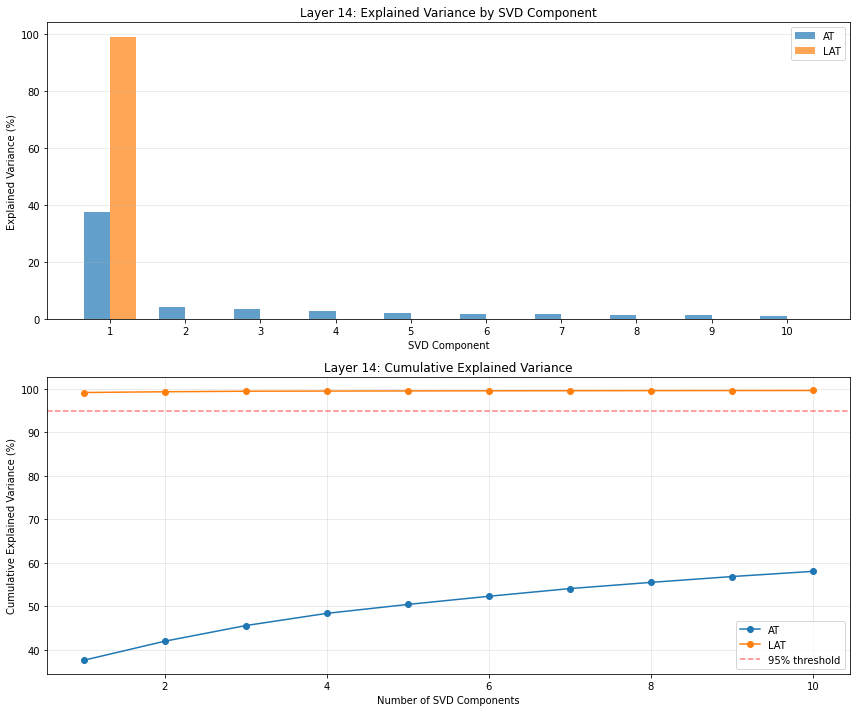


Explained variance at SVD component 1:
Baseline: 0.3756
LAT: 0.9917

Total variance explained by top 10 components:
Baseline: 0.5802
LAT: 0.9963


In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

n_components = 10
x = np.arange(n_components)
width = 0.35

# Bar plot - explained variance per component
ax1.bar(x - width/2, at_var[:n_components] * 100, width, label='AT', color='tab:blue', alpha=0.7)
ax1.bar(x + width/2, lat_var[:n_components] * 100, width, label='LAT', color='tab:orange', alpha=0.7)

ax1.set_xlabel('SVD Component')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_title(f'Layer {TARGET_LAYER}: Explained Variance by SVD Component')
ax1.set_xticks(x)
ax1.set_xticklabels(range(1, n_components + 1))
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

base_cum_var = np.cumsum(at_var)
lat_cum_var = np.cumsum(lat_var)

ax2.plot(range(1, n_components+1), base_cum_var[:n_components] * 100, 'o-', color='tab:blue', label='AT')
ax2.plot(range(1, n_components+1), lat_cum_var[:n_components] * 100, 'o-', color='tab:orange', label='LAT')
ax2.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% threshold')

ax2.set_xlabel('Number of SVD Components')
ax2.set_ylabel('Cumulative Explained Variance (%)')
ax2.set_title(f'Layer {TARGET_LAYER}: Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nExplained variance at SVD component 1:")
print(f"Baseline: {at_var[0]:.4f}")
print(f"LAT: {lat_var[0]:.4f}")

print(f"\nTotal variance explained by top {n_components} components:")
print(f"Baseline: {sum(at_var[:n_components]):.4f}")
print(f"LAT: {sum(lat_var[:n_components]):.4f}")

#### Further analysis based on Gorton et al. and Wollschlager et al. -- BAD ASSUMPTION

*NOTE*: This work was based on the assumption that I could use SVD components as a sort of analog for the dictionary of features that Gorton uses to calculate interference. So as we compute the gram matrix, we can see that its the identity matrix. So not sure what we're measuring, but its DEFINITELY not feature interfernce. 

In order to use Gorton's metric we need to do it on the basis vectors of the refusal subspace, rather than interference on per-sample differences from harmful[i] - harmless[i] vectors. We don't have access to a full dictionary of features (SAE) (which Gorton does), so we're using SVD components instead.

1. Compute per-sample difference vectors (harmful - harmless)
2. Extract basis vectors via SVD -- our assumption being that these are the refusal features
3. Compute Gram matrix on these basis vectors -- intuition here being that this is a sort of similarity scores for pairs of vectors in the set, see https://ecgraves.com/posts/gram-matrix-intuition/.
4. Extract off-diagonal interference metrics?

we would expect that **if latent AT reduces superposition like embeddings AT**
- the off diagonal interference should be lower (as found by Gorton)
- there should be lower number of dimensions which are used to represent refusal?

In [31]:
# compute refusal basis interference via SVD
N_COMPONENTS = 5

def compute_interference(diffs):
    _, _, Vt = np.linalg.svd(diffs, full_matrices=False)
    gram = Vt[:N_COMPONENTS] @ Vt[:N_COMPONENTS].T
    off_diag = gram[~np.eye(N_COMPONENTS, dtype=bool)]
    return gram, np.abs(off_diag).mean()

at_gram, at_mean_interference = compute_interference(
    (harmful_acts['AT'] - harmless_acts['AT']).cpu().float().numpy())
lat_gram, lat_mean_interference = compute_interference(
    (harmful_acts['LAT'] - harmless_acts['LAT']).cpu().float().numpy())

ratio = at_mean_interference / lat_mean_interference if lat_mean_interference > 0 else float('inf')
print(f"AT mean interference: {at_mean_interference:.10f}")
print(f"LAT mean interference: {lat_mean_interference:.10f}")
print(f"Ratio (AT/LAT): {ratio:.4f}x")

AT mean interference: 0.0000000065
LAT mean interference: 0.0000000092
Ratio (AT/LAT): 0.7076x


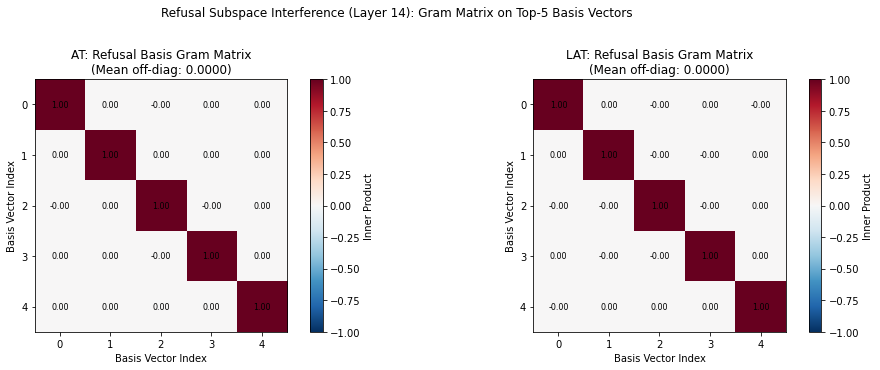

In [32]:
# visualize Gram matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, gram, mean_int) in zip(axes, [('AT', at_gram, at_mean_interference), 
                                              ('LAT', lat_gram, lat_mean_interference)]):
    im = ax.imshow(gram, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(f'{name}: Refusal Basis Gram Matrix\n(Mean off-diag: {mean_int:.4f})')
    ax.set_xlabel('Basis Vector Index')
    ax.set_ylabel('Basis Vector Index')
    plt.colorbar(im, ax=ax, label='Inner Product')
    
    for i in range(gram.shape[0]):
        for j in range(gram.shape[1]):
            ax.text(j, i, f'{gram[i, j]:.2f}', ha="center", va="center", color="black", fontsize=8)

plt.suptitle(f'Refusal Subspace Interference (Layer {TARGET_LAYER}): Gram Matrix on Top-{N_COMPONENTS} Basis Vectors', y=1.02)
plt.tight_layout()
plt.show()

#### Methods from superposition - participation ratio

Discussed in Elhage et al. as a measure of 'effective dimensionality'. This measures how many dimensions are used by a set of vectors. A PR of 1 means that all variance is concentrated in a single dimension. A PR of n means variance is equally spread across n dimensions.

If LAT reduces superposition, we would expect that the ratio for LAT would be lower than the ratio for AT or baseline

In [ ]:
def participation_ratio(activations):
    if isinstance(activations, torch.Tensor):
        activations = activations.cpu().float()
    
    # center the activations - what if we don't do this?
    #centered = activations - activations.mean(dim=0)
    
    # compute covariance matrix
    cov = (activations.T @ activations) / len(activations)
    
    # get eigenvalues
    eigenvalues = torch.linalg.eigvalsh(cov)
    eigenvalues = eigenvalues[eigenvalues > 1e-10]  # numerical stability
    
    # participation ratio
    pr = (eigenvalues.sum() ** 2) / (eigenvalues ** 2).sum()
    return pr.item(), eigenvalues.cpu().numpy()

# compute on difference vectors (harmful - harmless)
at_diffs = harmful_acts['AT'] - harmless_acts['AT']
lat_diffs = harmful_acts['LAT'] - harmless_acts['LAT']

at_pr, at_eigenvalues = participation_ratio(at_diffs)
lat_pr, lat_eigenvalues = participation_ratio(lat_diffs)

print(f"AT:  {at_pr:.2f} effective dimensions")
print(f"LAT: {lat_pr:.2f} effective dimensions")
print(f"Ratio (AT/LAT): {at_pr/lat_pr:.2f}x")

AT:  55.68 effective dimensions
LAT: 1.02 effective dimensions
Ratio (AT/LAT): 54.84x
